<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Network Attack</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import networkx as nx

import matplotlib
import matplotlib.pyplot as plt 

import tqdm as tq
from tqdm import tqdm

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 65ae48c468991275ad13ee5f183953d270e667f1

pandas    : 1.1.3
networkx  : 2.5
json      : 2.0.9
watermark : 2.1.0
numpy     : 1.19.2
matplotlib: 3.3.2
tqdm      : 4.62.0



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Zachary's Karate Club

We'll be using the Zachary Karate Club as our toy network

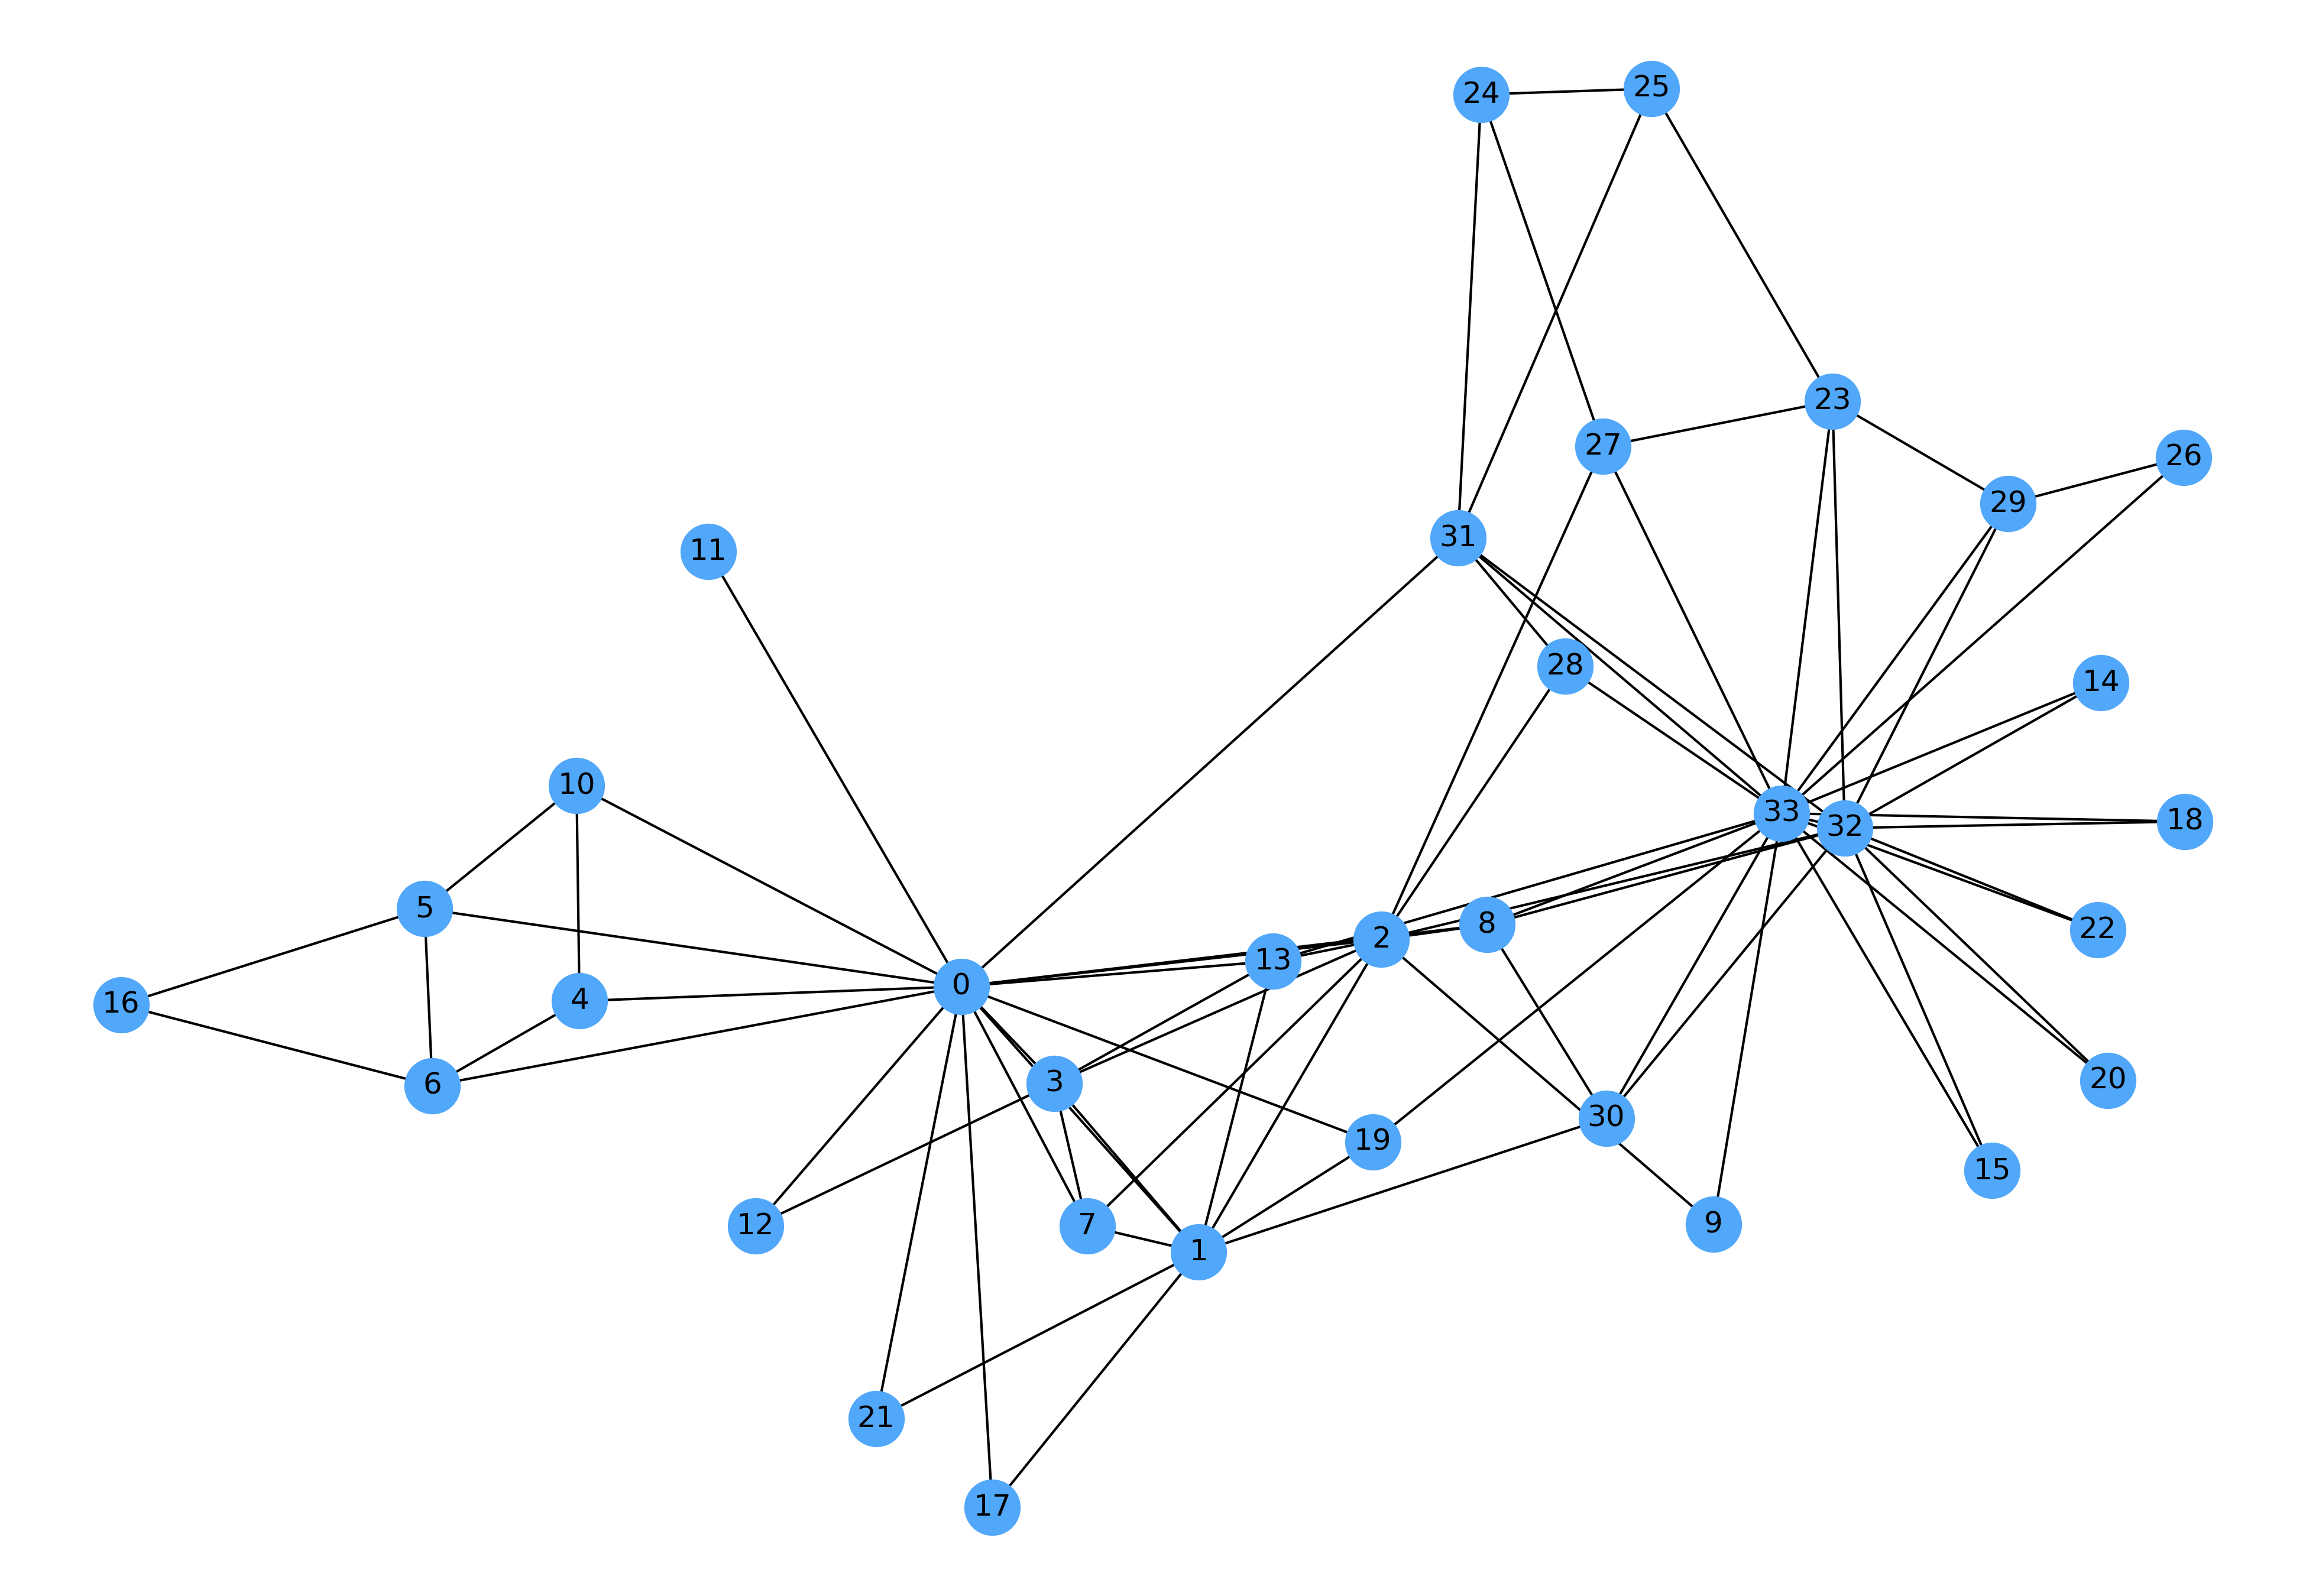

In [4]:
G = nx.karate_club_graph()
np.random.seed(123)
layout = nx.layout.spring_layout(G)
nx.draw(G, pos=layout, with_labels = True, node_color=colors[0], node_size=500)

In [5]:
degrees = dict(nx.degree(G))
N = G.number_of_nodes()

The average degree of the full graph is:

In [6]:
k_mean = sum(degrees.values())/N
k_mean

4.588235294117647

## Random selection

If we simply choose nodes at random, we obtain a fairly good sample of the graph and a good approximation of the actuall mean degree

In [7]:
mean_degree = 0
selected = set()

for i  in range(N):
    # Select a node at random
    random_node = np.random.randint(N)
    
    # Add the degree to the total value
    mean_degree += degrees[random_node]
    selected.add(random_node)

# Divide the total by the number of nodes sampled
mean_degree /= N

In [8]:
mean_degree

4.647058823529412

We visited the overwhelming majority of the nodes

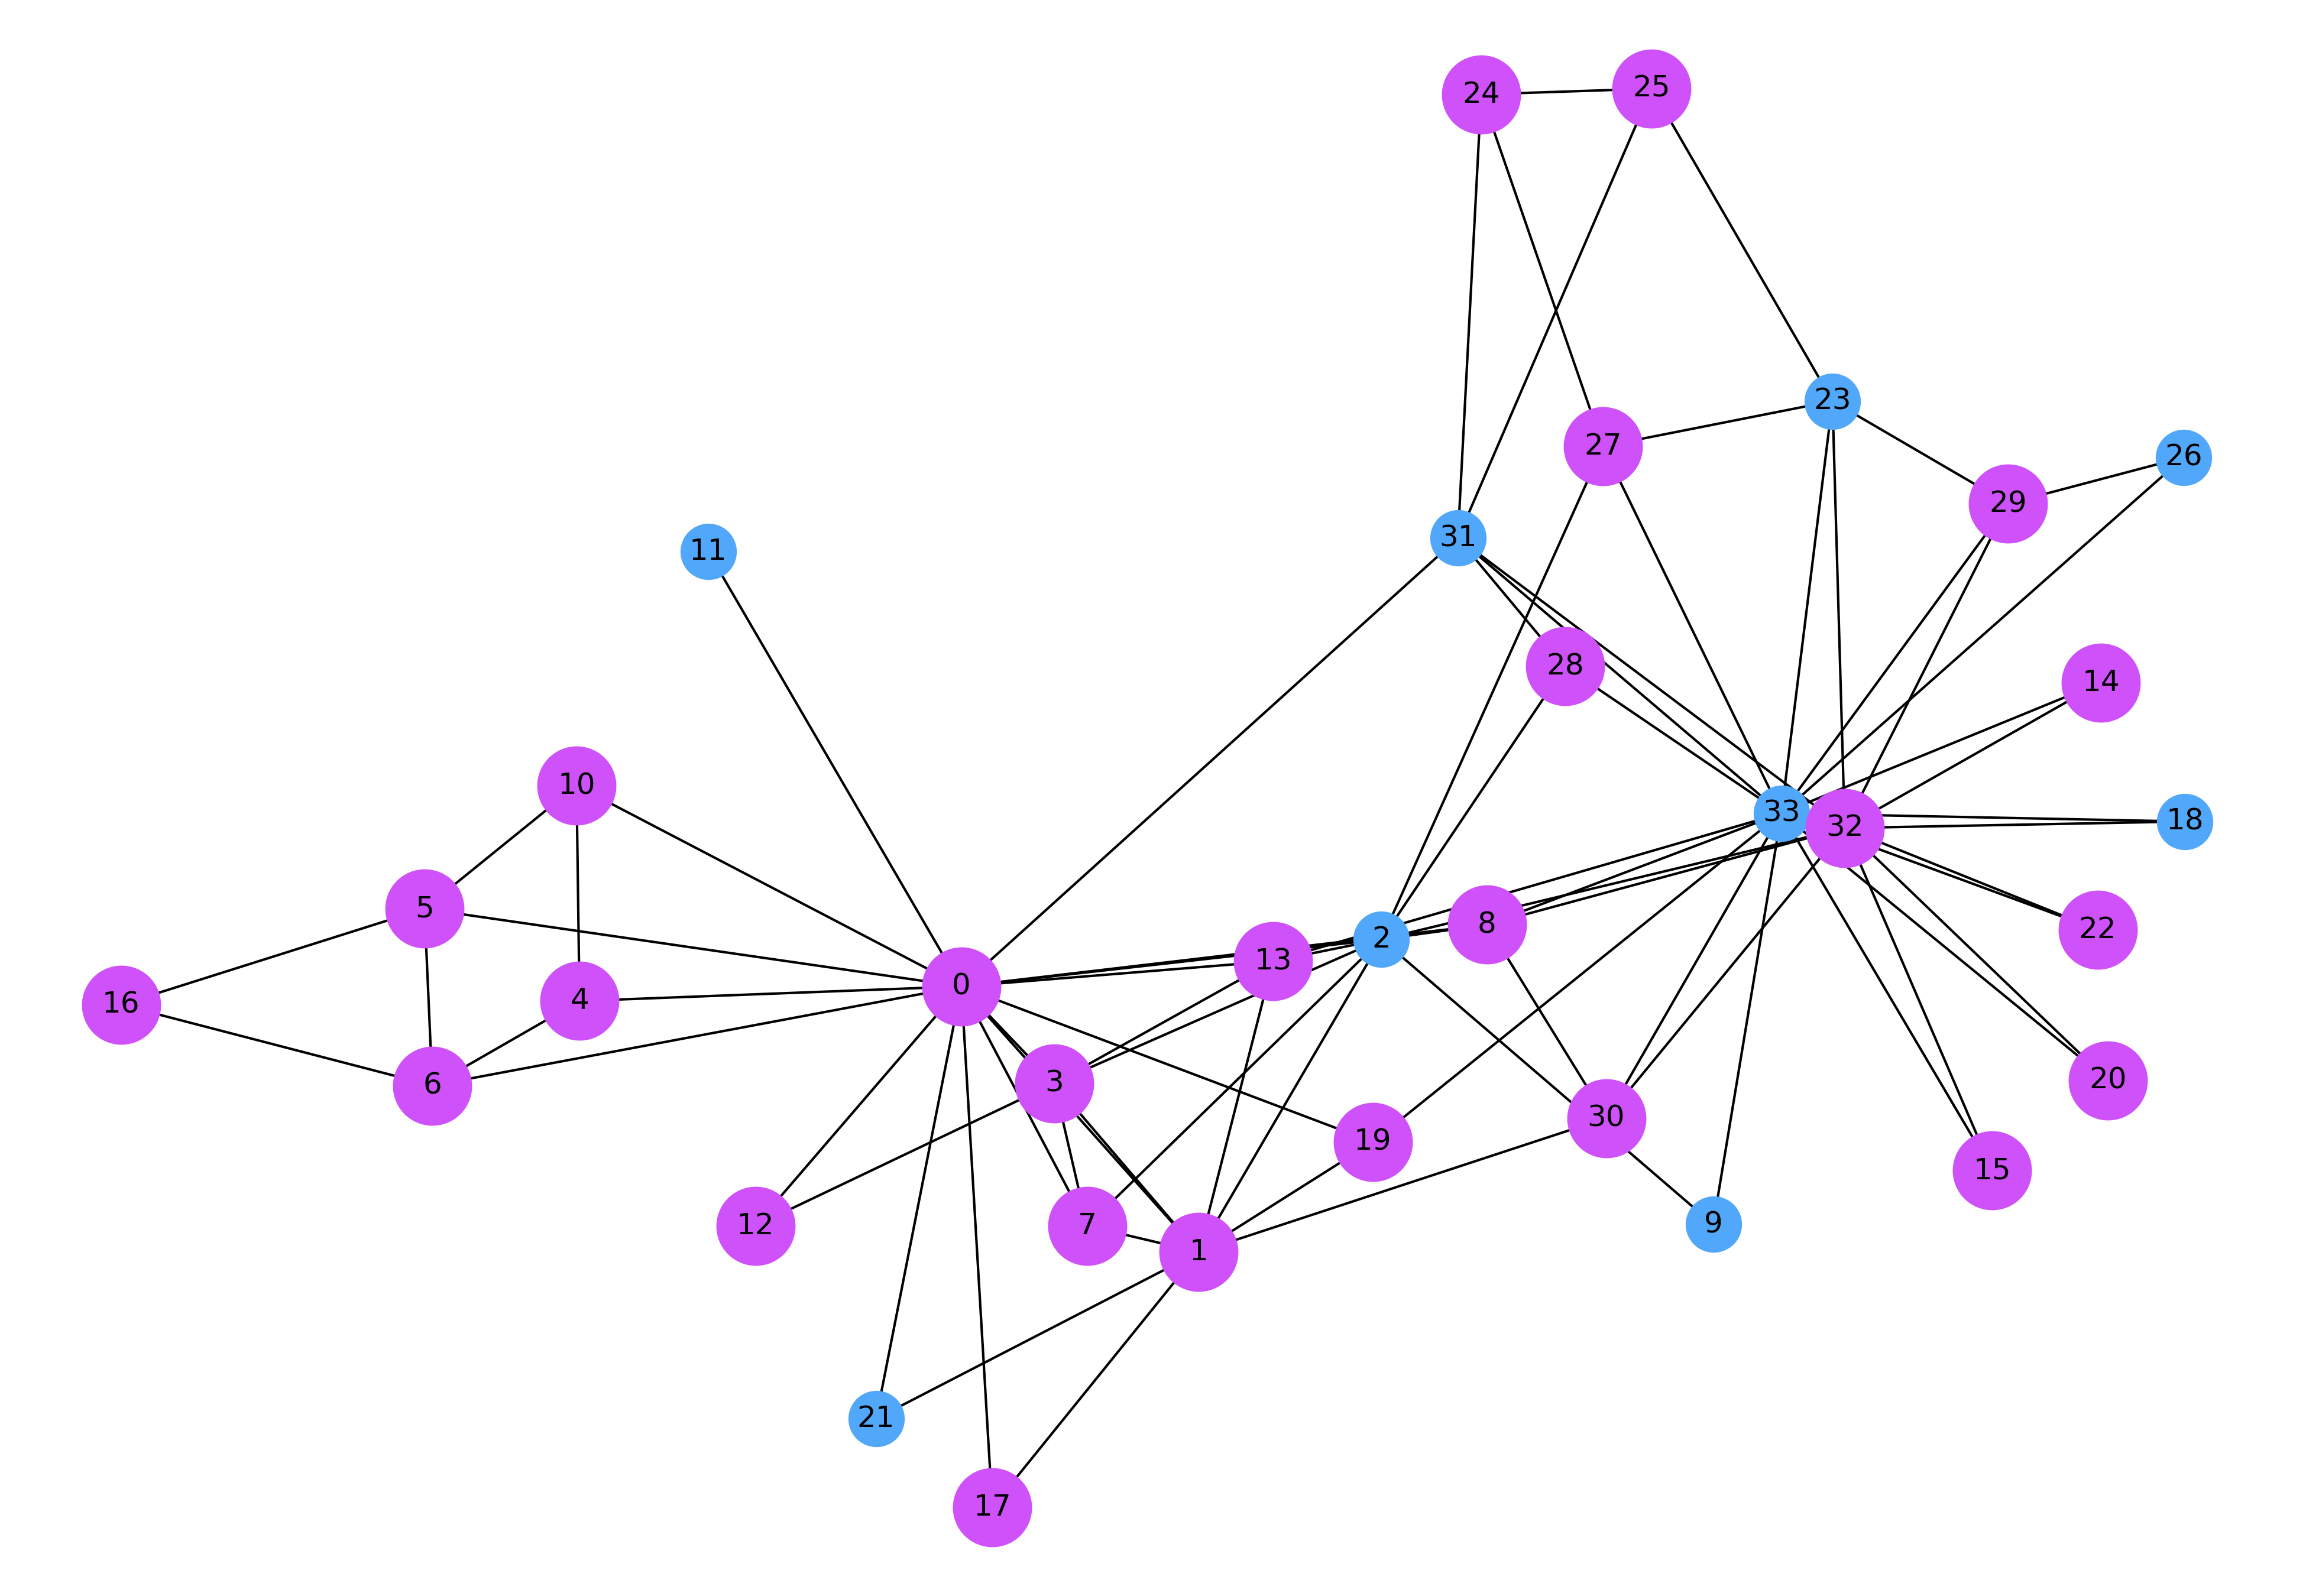

In [9]:
nx.draw(G, pos=layout, with_labels = True, node_color=colors[0], node_size=500)
nx.draw_networkx_nodes(G, pos=layout, nodelist=selected, node_color=colors[1], node_size=1000)

With some nodes visited more than once purely by chance, due to the random selection process we used

## Neighbor Selection

Now we consider the case where each node we select is asked to instead choose a neighbor at random

In [10]:
def select_random_neighbor(G, random_node):
    # Get the list of nearest neighbors
    NN = list(G.neighbors(random_node))

    # If the node doesn't have any neighbors
    # remove it instead
    if len(NN) == 0:
        return random_node
    
    # Choose a neighbor at random
    neighbor = NN[np.random.randint(len(NN))]

    return neighbor

Adding this extra step...

In [11]:
mean_degree = 0
selected = set()

for i  in range(G.number_of_nodes()):
    # Select a node at random
    random_node = np.random.randint(G.number_of_nodes())
    
    neighbor = select_random_neighbor(G, random_node)
    
    # Add the degree to the total value
    mean_degree += degrees[neighbor]
    selected.add(neighbor)

# Divide the total by the number of nodes sampled
mean_degree /= G.number_of_nodes()

Now the mean degree is much higher than the original one

In [12]:
mean_degree

9.029411764705882

As we select the hubs significantly more often than other nodes due to degree correlations

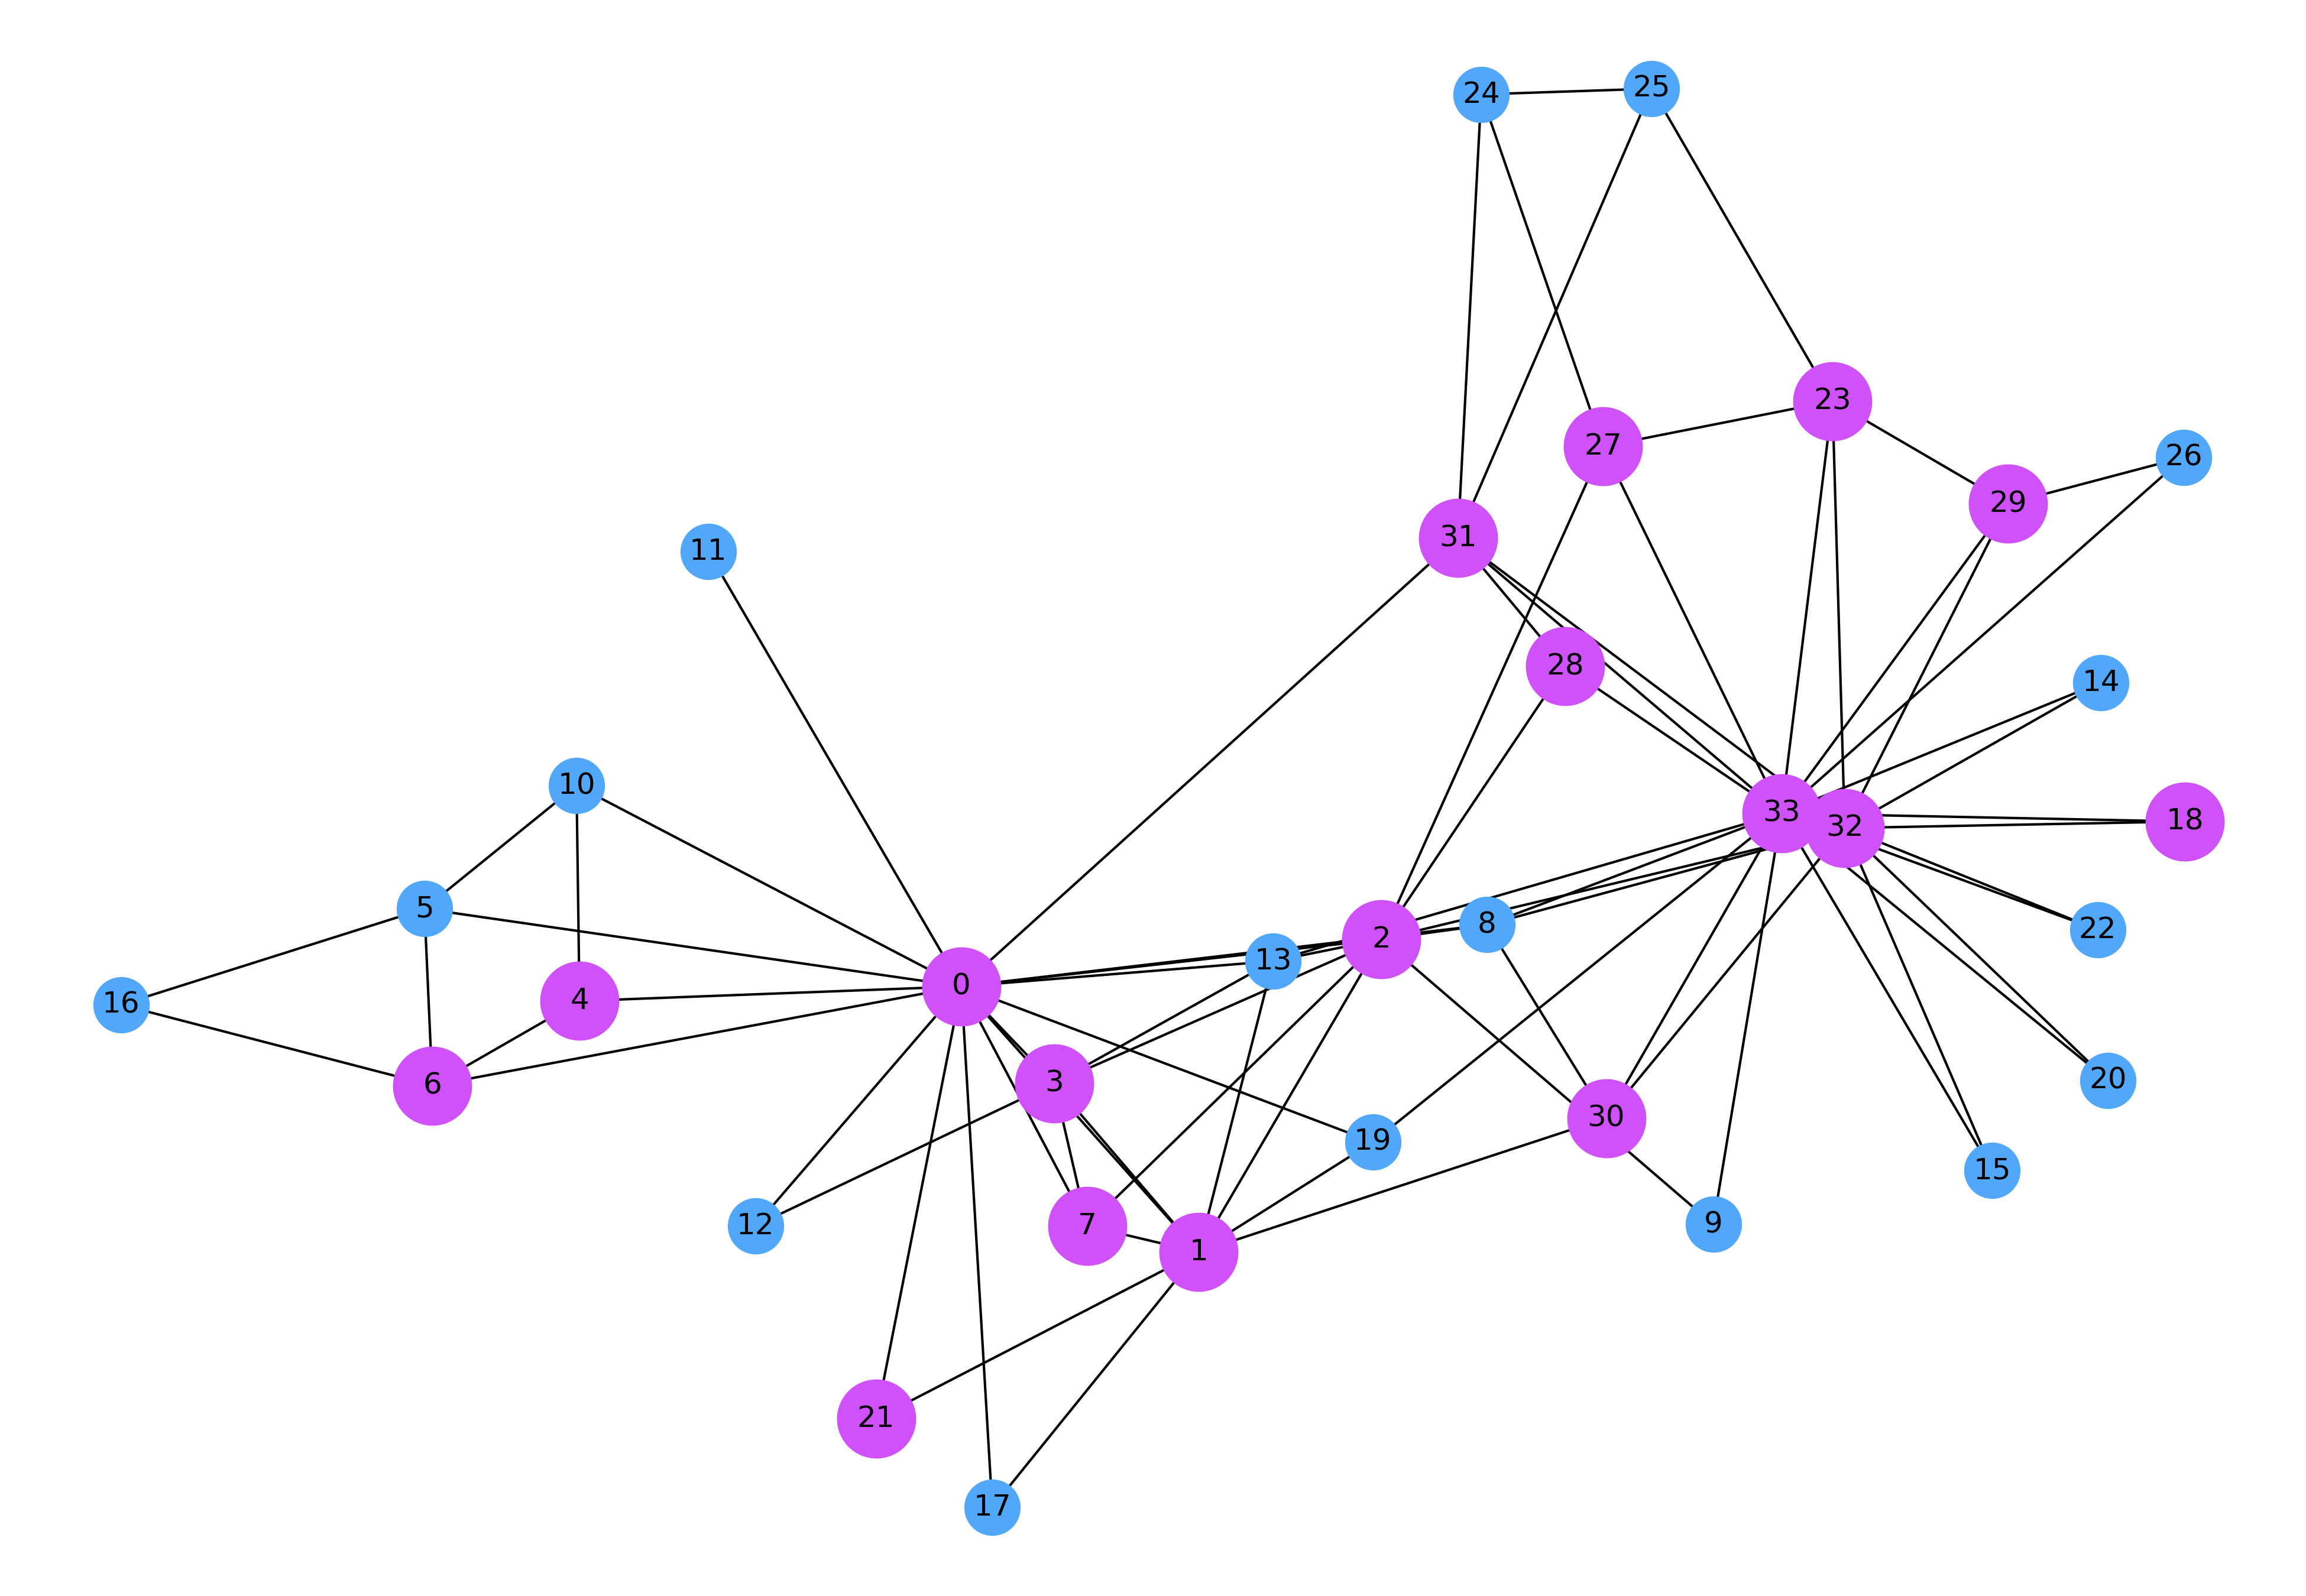

In [13]:
nx.draw(G, pos=layout, with_labels = True, node_color=colors[0], node_size=500)
nx.draw_networkx_nodes(G, pos=layout, nodelist=selected, node_color=colors[1], node_size=1000)

In [14]:
len(selected)

17

# Slashdot social network

In [15]:
data = pd.read_csv('data/soc-Slashdot0811.txt.gz', header=None, 
                   comment='#', sep='\t', names=["node_i", "node_j"])

In [16]:
data.head()

,node_i,node_j
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


Our dataset has 905,468 rows, one for each edge

In [17]:
data.shape

(905468, 2)

We use networkX to generate a directed graph

In [18]:
G = nx.DiGraph()
G.add_edges_from(data.values)

In total, we have 77,360 nodes

In [19]:
G.number_of_nodes()

77360

and 905,468 edges, as expected

In [20]:
G.number_of_edges()

905468

forming a single weakly connected component

In [21]:
len(list(nx.weakly_connected_components(G)))

1

## Random removal of nodes

We start by trying the random removal of nodes approach. We create a copy of the graph so that we can remove each node in turn to check the effect on the graph structure

In [22]:
G_random = G.copy()

In [23]:
NCC_random = [len(list(nx.weakly_connected_components(G_random)))]
GCC_random = [nx.number_of_nodes(G)]

for i in tqdm(range(1, 2001), total=2000):
    nodes = list(G_random.nodes())
    random_node = nodes[np.random.randint(len(nodes))]
    
    G_random.remove_node(random_node)
    
    CC = list(nx.weakly_connected_components(G_random))
    NCC_random.append(len(CC))
    GCC_random.append(np.max([len(comp) for comp in CC]))

100%|██████████| 2000/2000 [09:18<00:00,  3.58it/s]


And compare with the results obtained from removing a neighbor of the randomly selected nodes.

## Removal of random neighbors

In [24]:
G_neighbor = G.copy()

In [25]:
NCC_neighbor = [len(list(nx.weakly_connected_components(G)))]
GCC_neighbor = [nx.number_of_nodes(G)]

for i in tqdm(range(1, 2001), total=2000):
    nodes = list(G_neighbor.nodes())
    random_node = nodes[np.random.randint(len(nodes))]

    neighbor = select_random_neighbor(G_neighbor, random_node)
    
    G_neighbor.remove_node(neighbor)
    
    CC = list(nx.weakly_connected_components(G_neighbor))
    NCC_neighbor.append(len(CC))
    GCC_neighbor.append(np.max([len(comp) for comp in CC]))

100%|██████████| 2000/2000 [09:35<00:00,  3.47it/s]


## Number of Connected Components

The comparison is striking! After removing just 200 (0.26%) neighbors, we've managed to break the network up into hundreds of components.

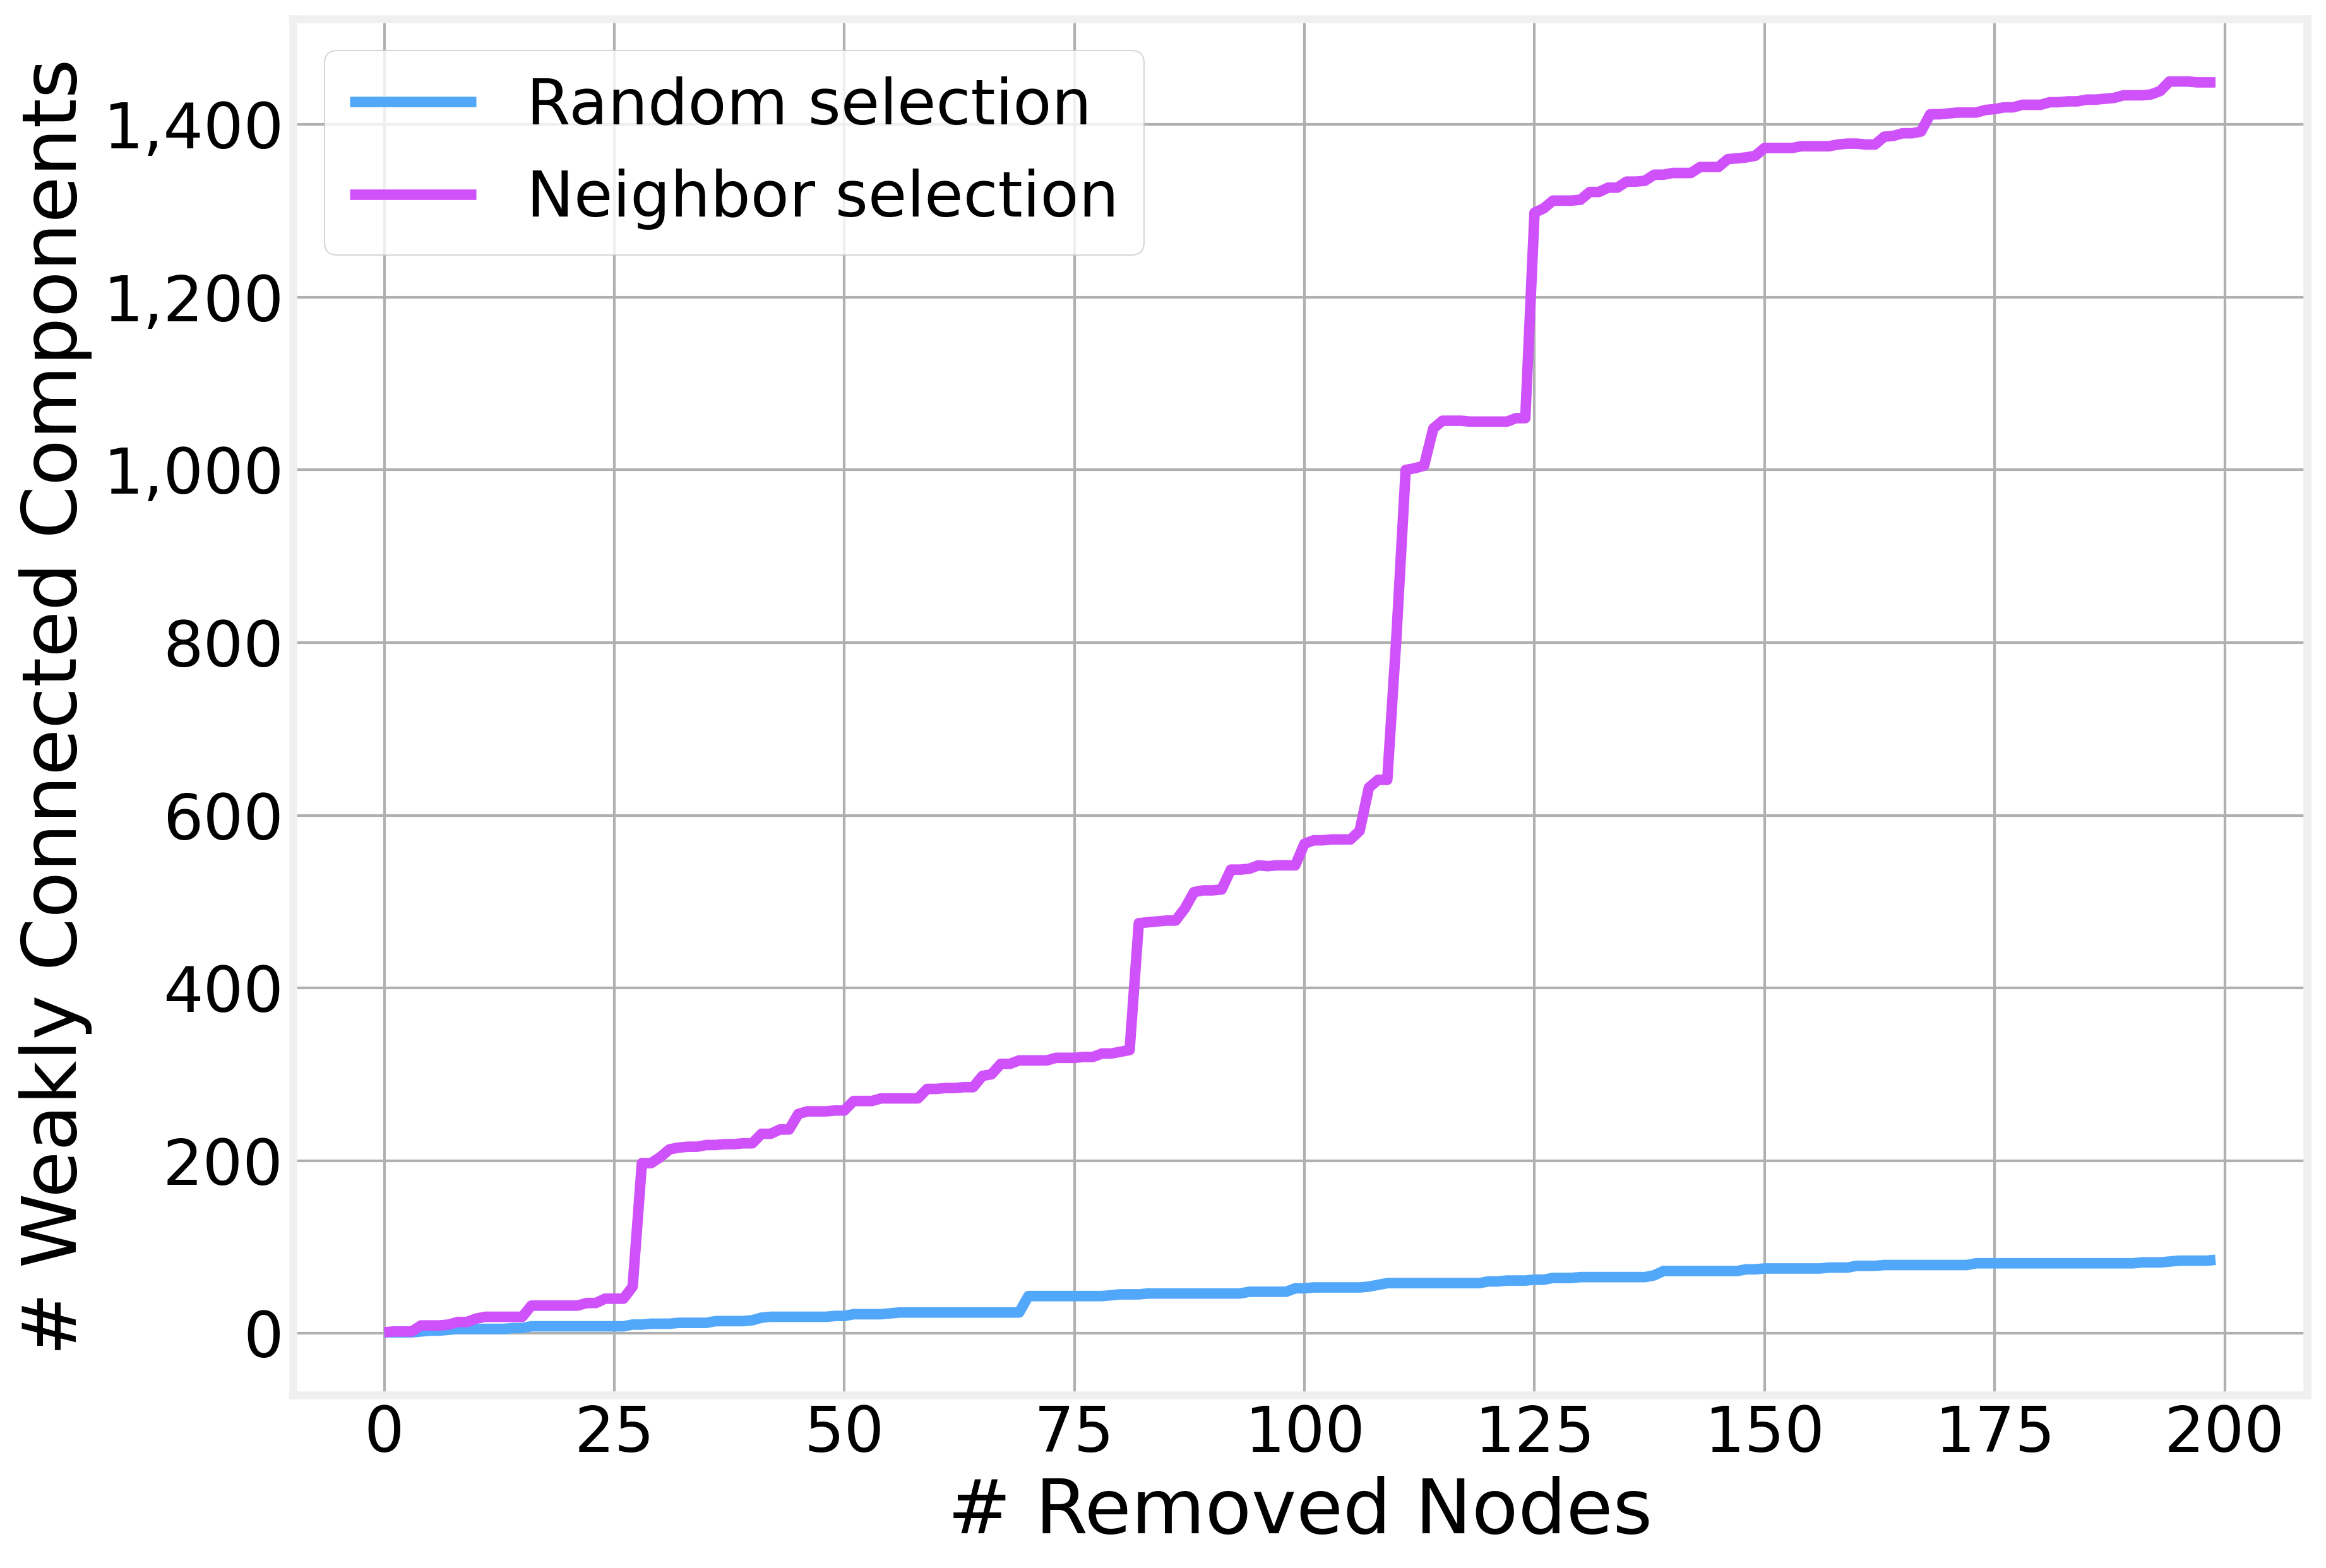

In [26]:
fig, ax = plt.subplots(1)
ax.plot(NCC_random[:200])
ax.plot(NCC_neighbor[:200])
ax.legend(['Random selection', 'Neighbor selection'])
ax.set_xlabel('# Removed Nodes')
ax.set_ylabel('# Weakly Connected Components')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

## Size of the largest Connected Component

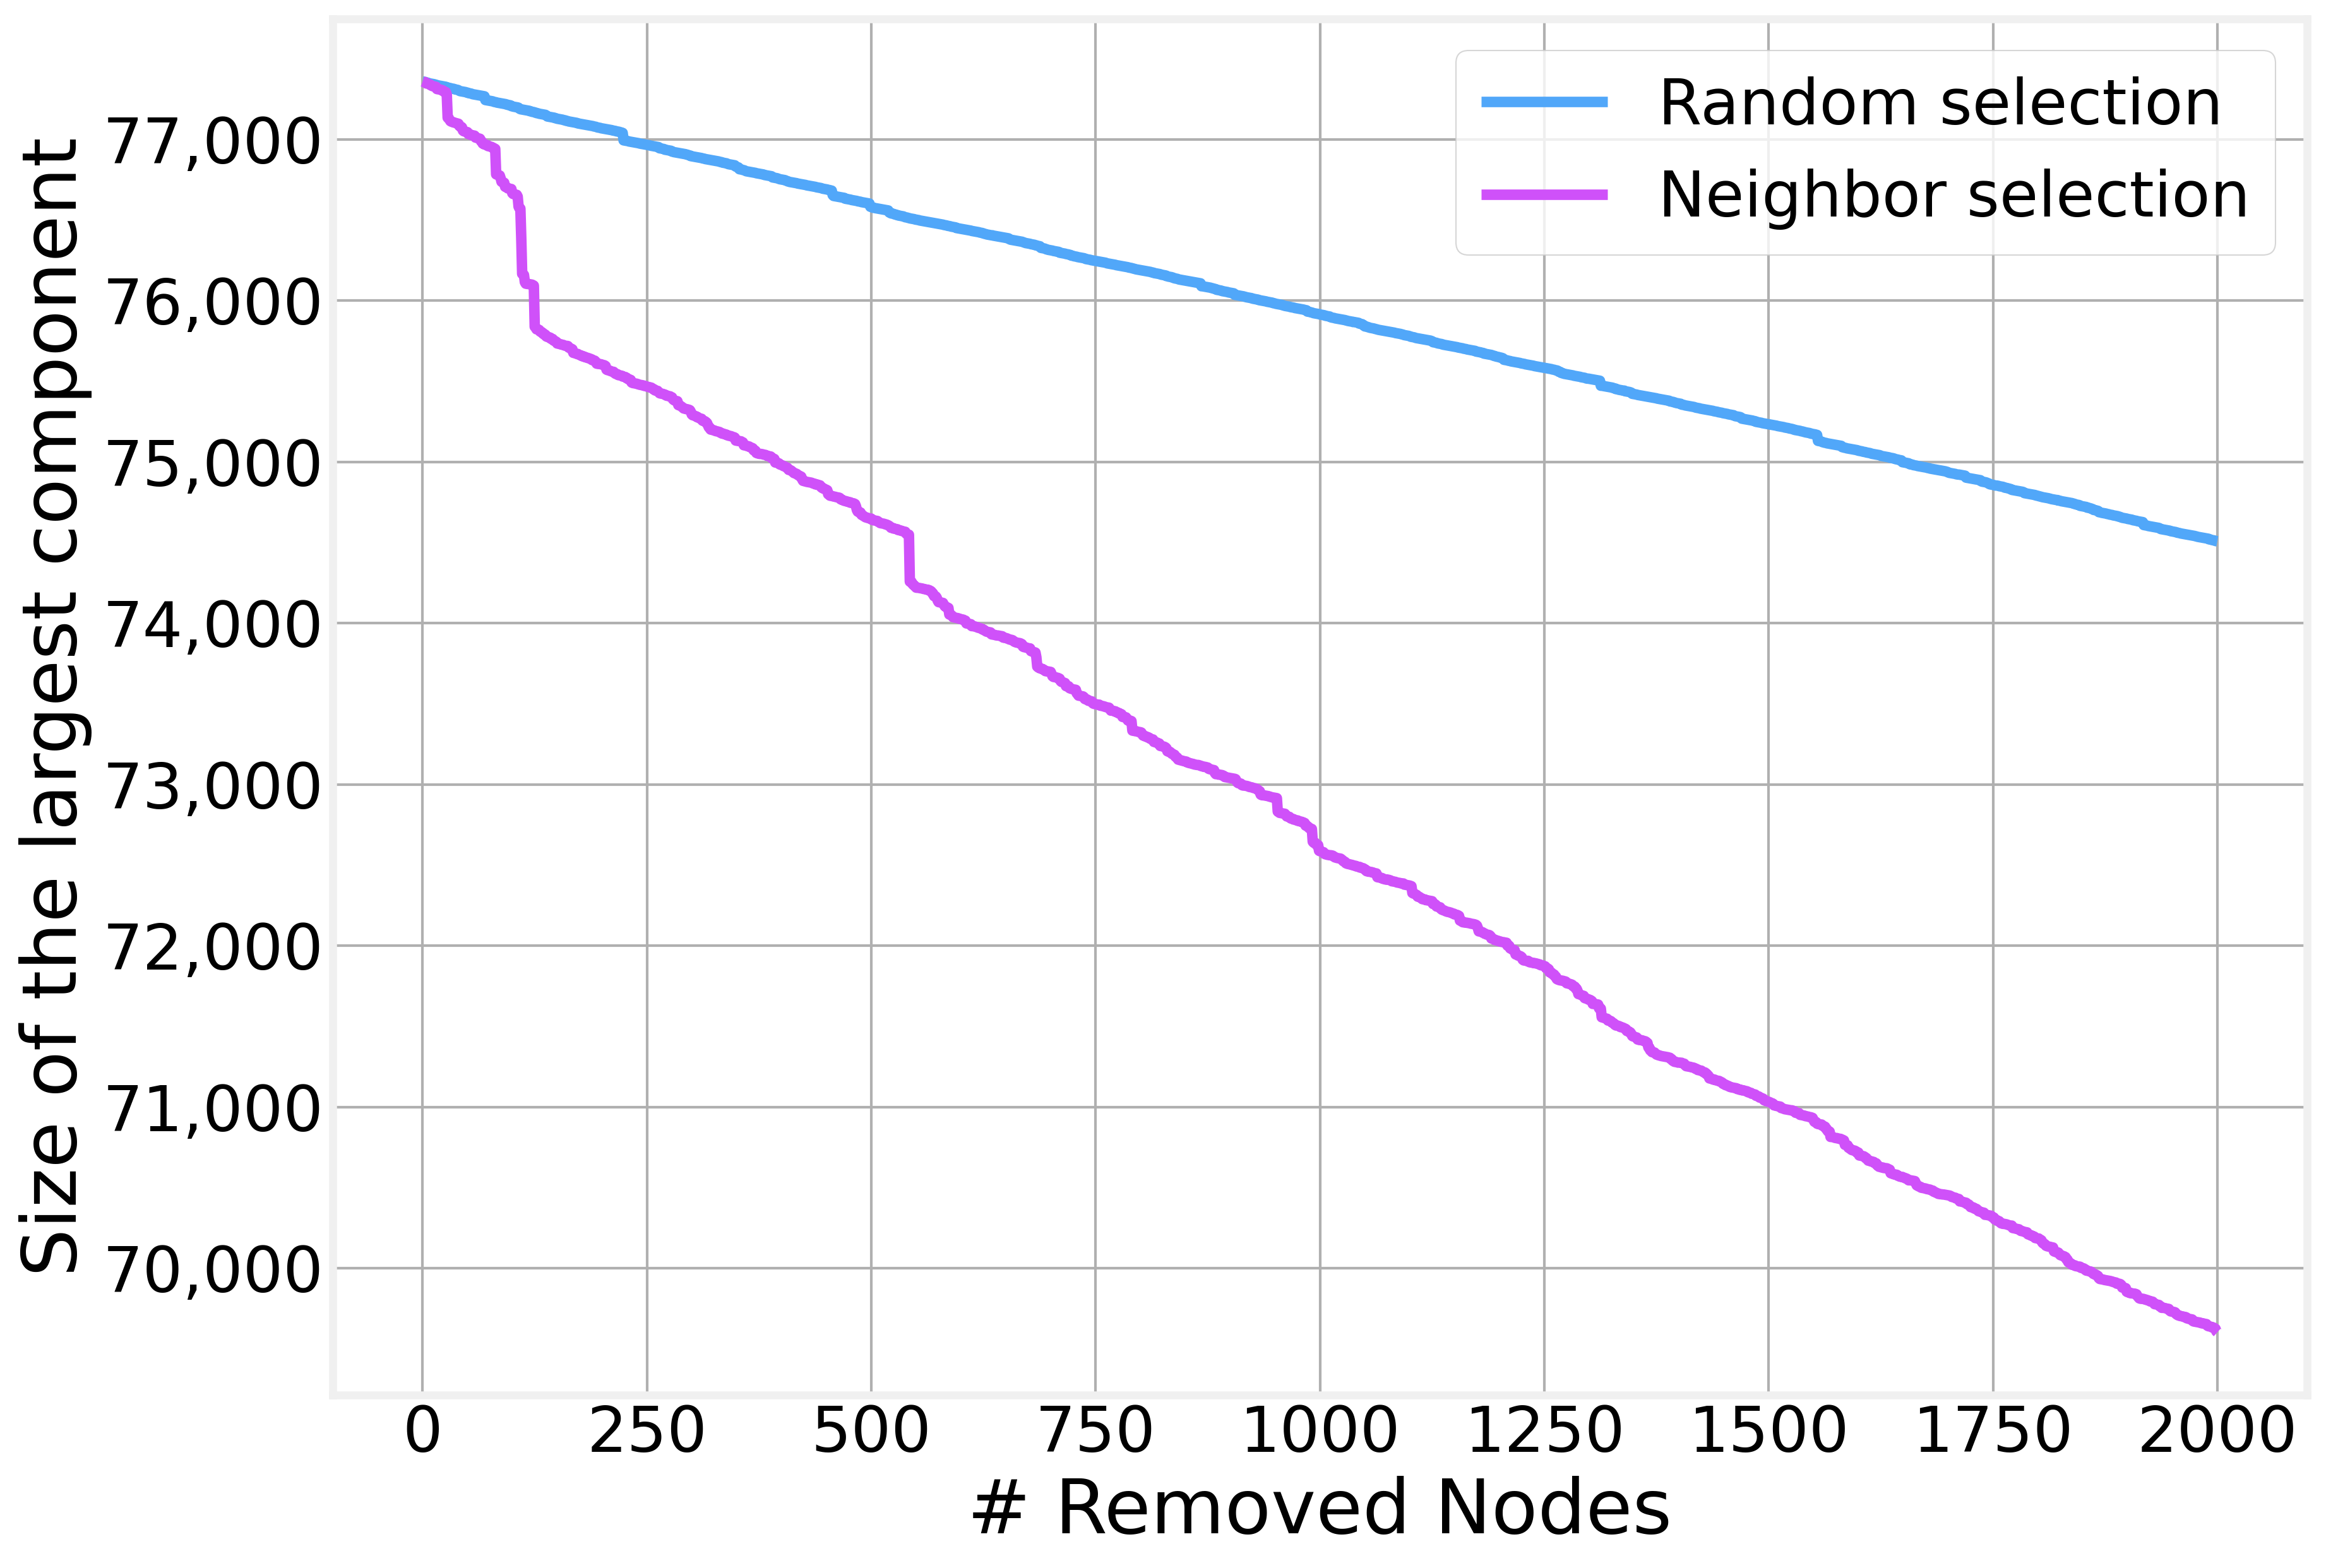

In [27]:
fig, ax = plt.subplots(1)
ax.plot(GCC_random)
ax.plot(GCC_neighbor)
ax.legend(['Random selection', 'Neighbor selection'])
ax.set_xlabel('# Removed Nodes')
ax.set_ylabel('Size of the largest component')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>